In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import reshape, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

from hython.utils import missing_location_idx, reconstruct_from_missing, load
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [194]:
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer'] #, 'TT', 'KsatHorFrac'] 
target_names = [ "vwc","actevap" ] # "q_river"]

fn_forcings =  "forcings.nc"  # 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc' 
fn_params = "staticmaps.nc"
fn_targets = "output.nc"


timeslice = slice("2016-01-01","2020-12-31")

In [195]:
# DEMO 

# wflow_model = "datademo" #"adg1km_eobs" #"datademo" # "alps1km_eobs" # "alps1km_cerra", 

# wd = Path("../data") / wflow_model

# fp_dynamic_forcings = wd / fn_forcings 
# fp_wflow_static_params = wd / fn_params
# fp_target = wd / fn_targets

# forcings = xr.open_dataset(fp_dynamic_forcings)
# params = xr.open_dataset(fp_wflow_static_params)
# targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [196]:
# EURAC FILE SYSTEM

wflow_model =  "adg1km_eobs" # "alps1km_eobs" #

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models") / wflow_model

input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
output_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/surrogate/')
model_weigths_path = output_dir_path / "model_weights"
surrogate_input_path = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

forcings = xr.open_dataset(input_dir_path / fn_forcings , chunks= {"time":100})
params = xr.open_dataset(input_dir_path / fn_params ,  chunks= {"time":100}).sel(layer=1)
targets = xr.open_dataset(input_dir_path / "run_default" / fn_targets, chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))

In [197]:
#(surrogate_input_path / f"{wflow_model}.npz").exists()

In [198]:
# select forcings, wflow parameters and targets
forcings = forcings[dynamic_names]
params = params[static_names]
targets = targets[target_names] 

In [199]:
## Show distribution of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot.hist(bins=100)

In [200]:
## Show map of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot()

In [201]:
try:
    forcings = forcings.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

# Hyper parameters

In [202]:
# training 

spatial_batch_size = 128
temporal_sampling_size = 150 
seq_length = 260 # days

# model 

hidden_size = 32

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

In [203]:
remove_lakes = True

if remove_lakes:
    mask_lakes = (targets.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    targets = targets.where(~mask_lakes, np.nan)
    forcings = forcings.where(~mask_lakes, np.nan)
    params = params.where(~mask_lakes, np.nan)


if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [204]:
# UNCOMMENT IF NOT LOADING PREPROCESSED INPUTS

#reshape for training

Xd, Xs, Y  = reshape(
                   forcings, 
                   params, 
                   targets
                   )

#Define the 2D missing values mask. Sampling 

missing_mask = np.isnan(params[static_names[0]]).values

# UNCOMMENT TO SAVE
# np.savez_compressed( surrogate_input_path / f"{wflow_model}", Xd=Xd, Xs=Xs, Y=Y, missing_mask = missing_mask)

dynamic:  (40140, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (40140, 5)  => (GRIDCELL, FEATURE)
target:  (40140, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [205]:
# UNCOMMENT IF LOADING PREPROCESSED INPUTS
# Xd, Xs, Y, missing_mask = load(surrogate_input_path, wflow_model, files = ["Xd", "Xs", "Y", "missing_mask"])
# Xd.shape, Xs.shape, Y.shape, missing_mask.shape

In [206]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

intervals = (5, 5) # every n km
train_origin = (0, 0)
val_origin = (3, 3)

spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

In [207]:
# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.

data2d  = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

In [208]:
# some useful metadata
sampler_train_meta

SamplerResult(
 - id_grid_2d: (180, 223) 
 - idx_sampled_1d: (1620,) 
 - idx_sampled_1d_nomissing: (622,)) 
 - idx_missing_1d: (24714,) 
 - sampled_grid_dims: (36, 45, 1827, 3) 
 - xr_coords: Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-31
  * lon          (lon) float64 10.29 10.34 10.38 10.43 ... 12.22 12.26 12.31
  * lat          (lat) float64 47.08 47.04 46.99 46.94 ... 45.57 45.52 45.48
    spatial_ref  int64 ...
    layer        float64 1.0

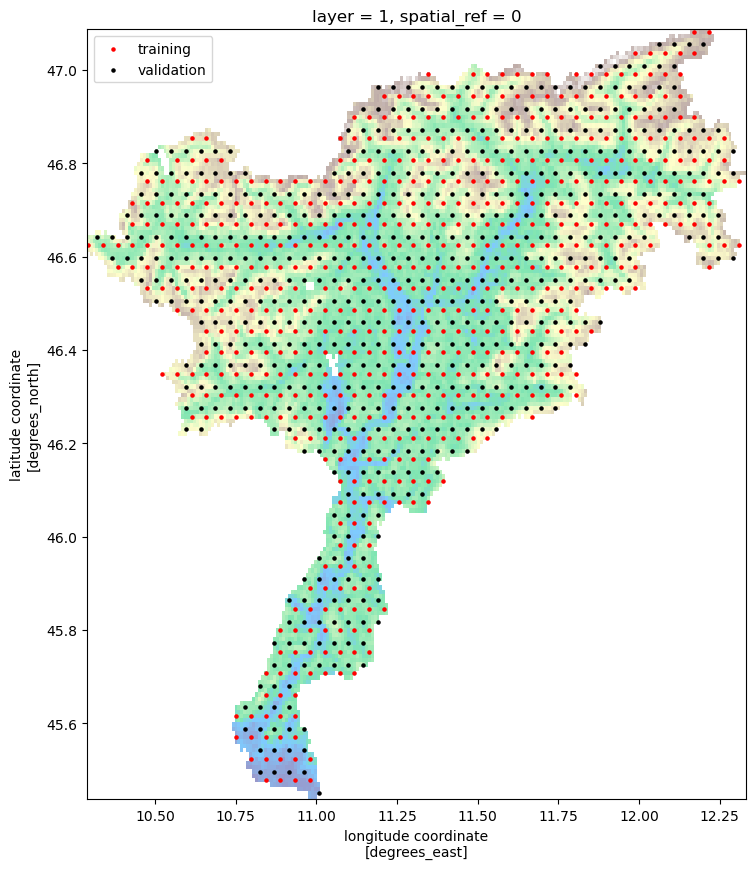

In [209]:
# check location of training and validation sets
_ = plot_sampler(params[static_names[0]], sampler_train_meta, sampler_val_meta, figsize= (10, 10 ), markersize = 5)

In [210]:
# # Normalizing
# # training
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

#print("dynamic mean ",d_m, "dynamic std", d_std, "static mean",s_m, "static std", s_std, "target mean", y_m, "target std", y_std, sep="\n")

In [211]:
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std)
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std)

In [212]:
## Show distribution of static parameters
# for i in range(Xs.shape[1]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

In [213]:
## Show distribution of targets
# for i in range(Y.shape[2]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

In [214]:
np.isnan(Xd[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_val_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

In [215]:
np.isnan(Xd[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_train_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

# Prepare Model inputs

In [216]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

Xs.shape, Xd.shape, Y.shape

(torch.Size([40140, 5]),
 torch.Size([40140, 1827, 3]),
 torch.Size([40140, 1827, 2]))

In [217]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [218]:
train_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

In [219]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

# Initialize Model

In [220]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=8, out_features=32, bias=True)
  (lstm): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=2, bias=True)
)

# Train/valid settings

In [221]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-2)


loss_fn = RMSELoss(target_weight={"actevap":0.5, "vwc":0.5})

metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 20

params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [222]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

Epoch 0/19, current lr=0.01
Copied best model weights!
train loss: 0.59701007604599, train metric: {'vwc': 0.41635677, 'actevap': 0.24268399}
val loss: 0.5466952919960022, val metric: {'vwc': 0.2846521, 'actevap': 0.24270254}
----------
Epoch 1/19, current lr=0.01
Copied best model weights!
train loss: 0.49004295468330383, train metric: {'vwc': 0.24815841, 'actevap': 0.18261398}
val loss: 0.4974358379840851, val metric: {'vwc': 0.2762119, 'actevap': 0.1649862}
----------
Epoch 2/19, current lr=0.01
Copied best model weights!
train loss: 0.4626252353191376, train metric: {'vwc': 0.23413162, 'actevap': 0.15970786}
val loss: 0.4437463879585266, val metric: {'vwc': 0.21535793, 'actevap': 0.13918492}
----------
Epoch 3/19, current lr=0.01
Copied best model weights!
train loss: 0.4301084578037262, train metric: {'vwc': 0.18006708, 'actevap': 0.15931875}
val loss: 0.42315447330474854, val metric: {'vwc': 0.14861526, 'actevap': 0.1530628}
----------
Epoch 4/19, current lr=0.01
Copied best mode

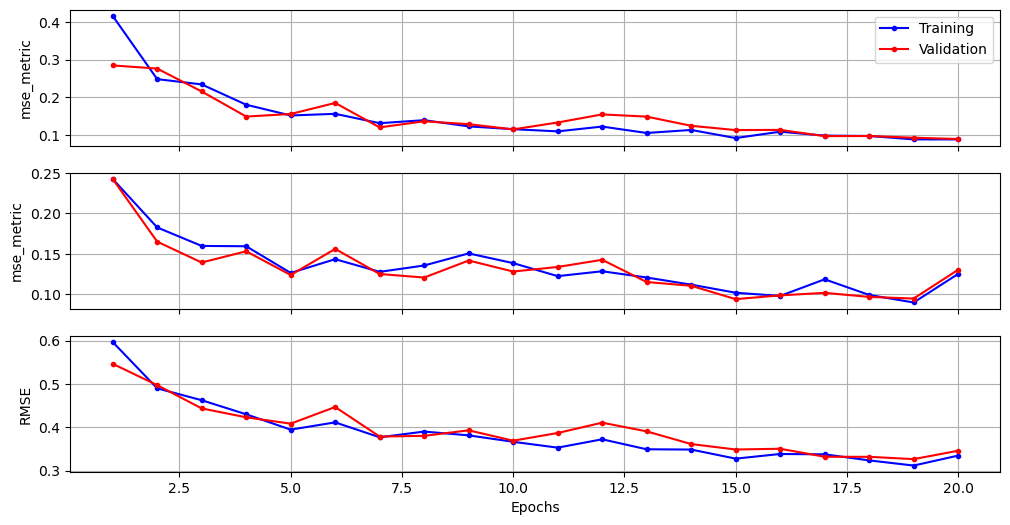

In [243]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [224]:
#model.load_state_dict(torch.load(params_train["path2weights"]))

# Inference 

In [225]:
torch.cuda.empty_cache()

In [226]:
# predict over the whole spatial domain using the model trained over the subsample
yhat = predict(Xd, Xs, model, spatial_batch_size, device=device)
yhat.shape

(40140, 1827, 2)

In [227]:
lat, lon, time = *forcings.to_dataarray().transpose("lat","lon", "time", "variable").shape[:2], Xd.shape[1]
lat*lon ,time

(40140, 1827)

In [228]:
yhat = (yhat*y_std) + y_m

## SM

In [229]:
# reshape data for plotting
y_target, y_pred = prepare_for_plotting(y_target=Y[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets.coords)
y_target.shape

(180, 223, 1827)

In [230]:
y_target = (y_target*y_std[0]) + y_m[0]

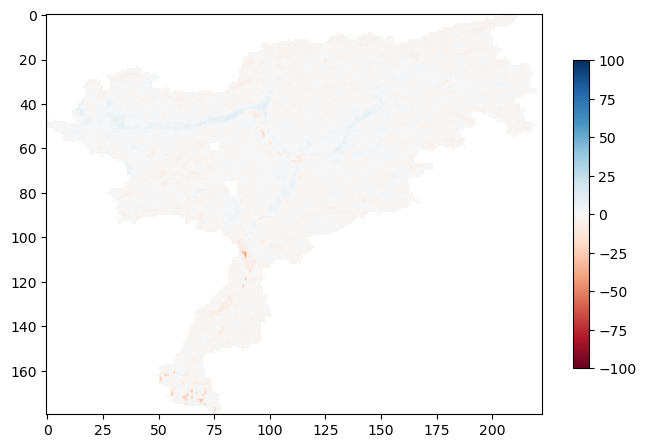

In [231]:
# map percent bias
map_pbias(y_target, y_pred, figsize = (8, 8), kwargs_imshow = {"vmin":-100, "vmax":100 })

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


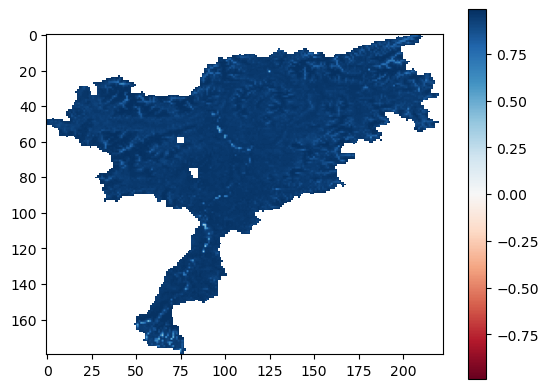

In [232]:
# correlation
map_pearson(y_target, y_pred)

In [233]:
#plt.plot(np.unique(y_pred))

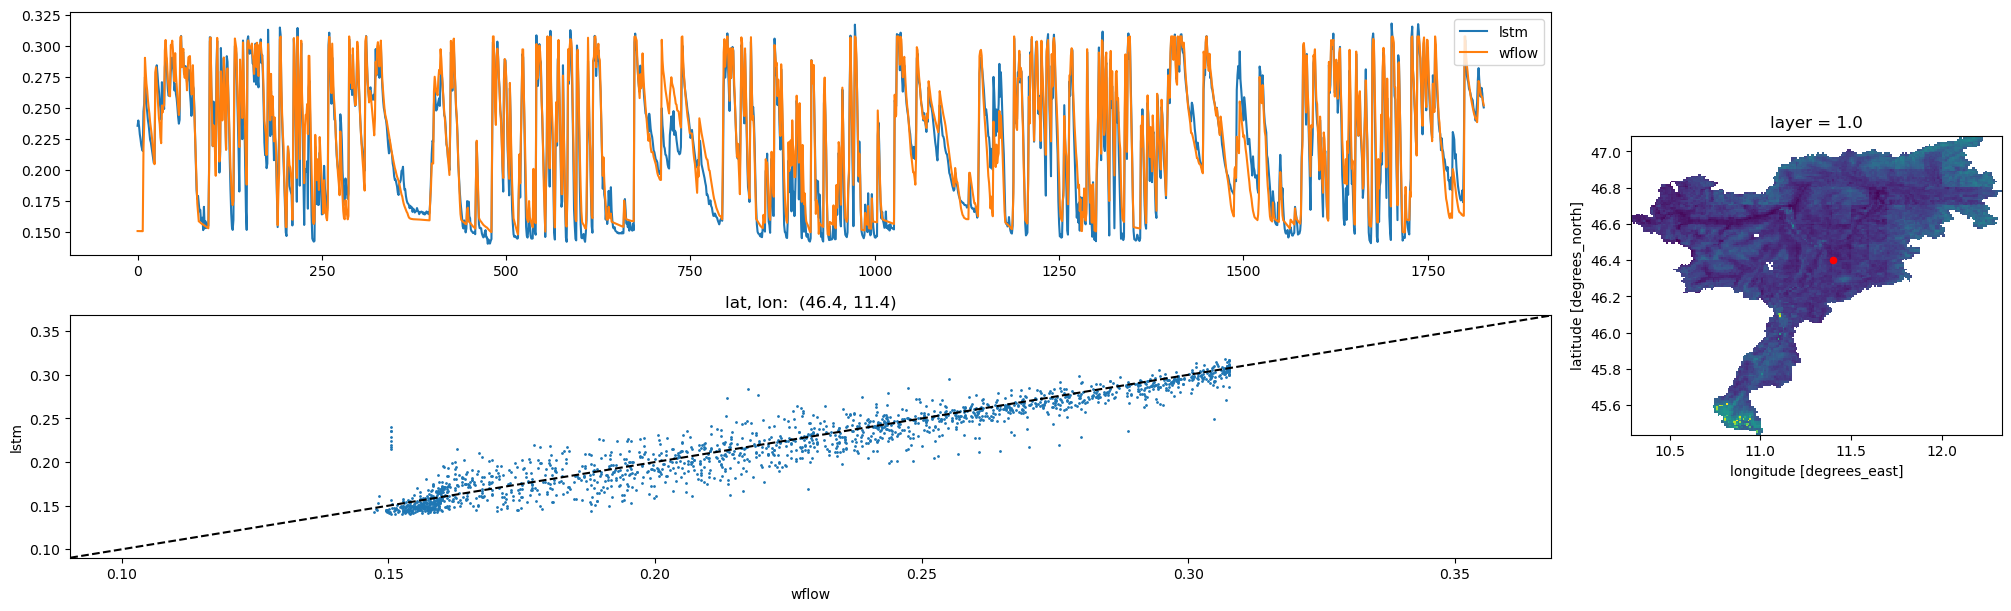

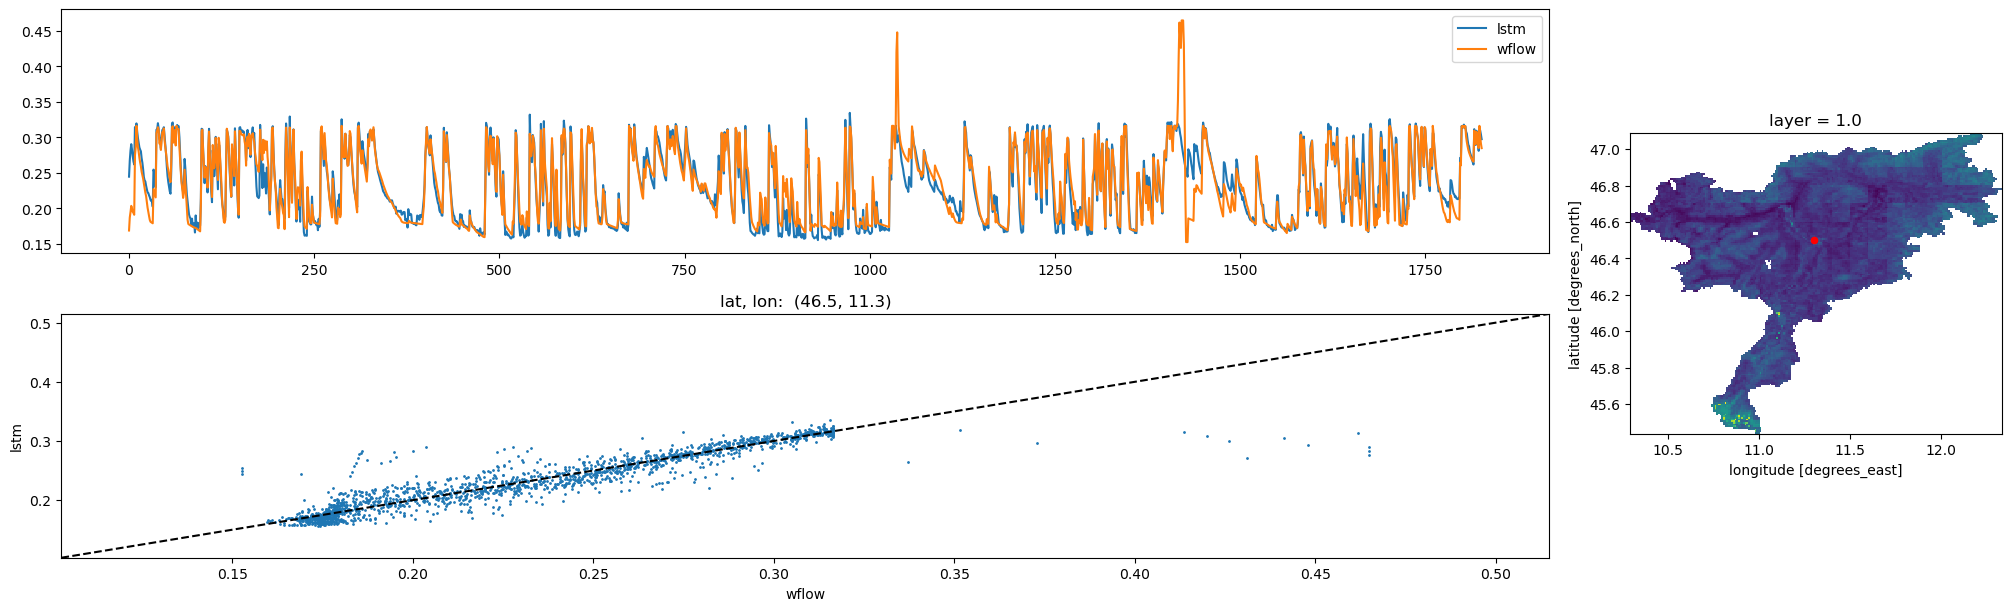

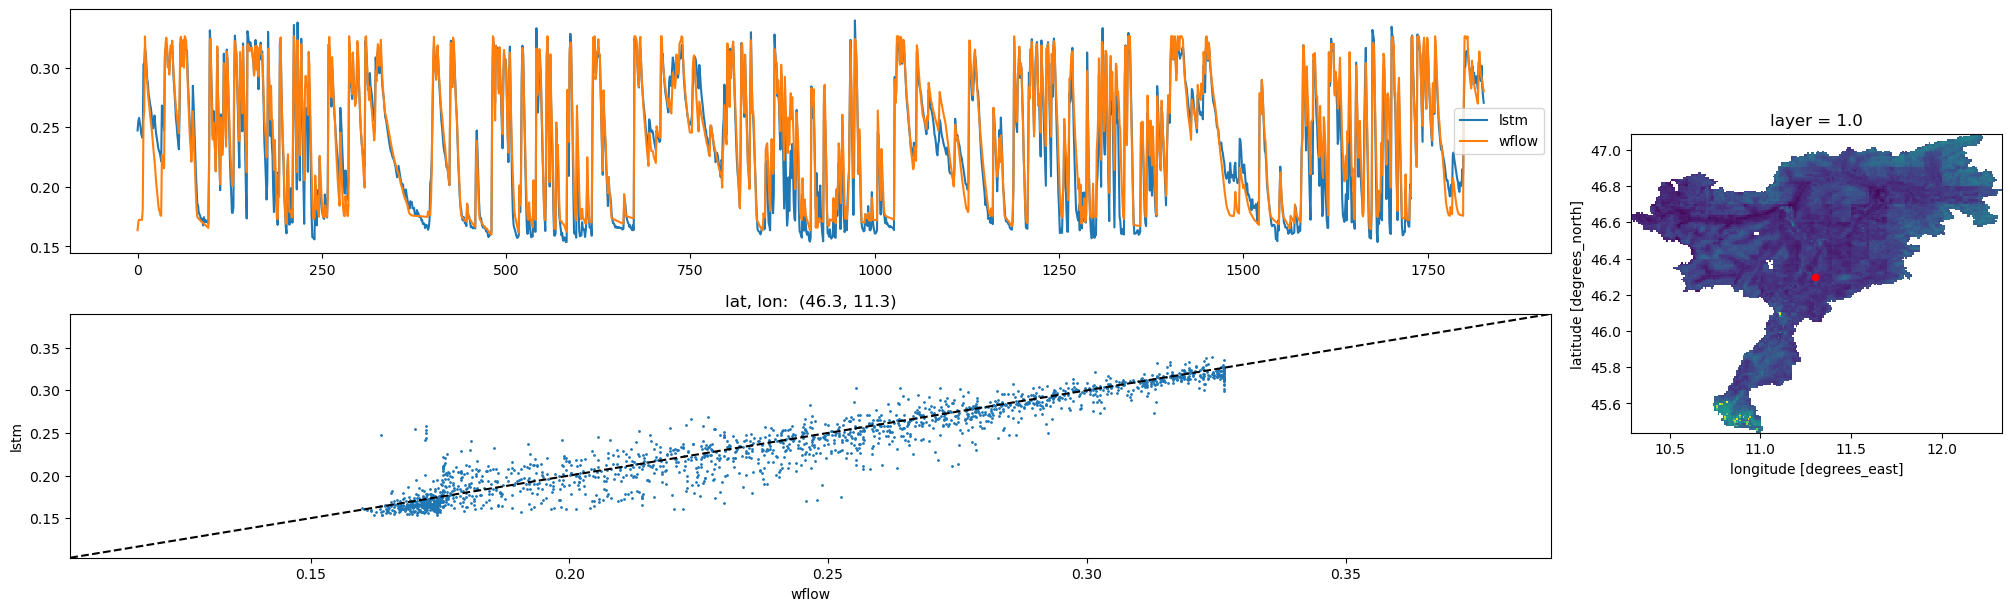

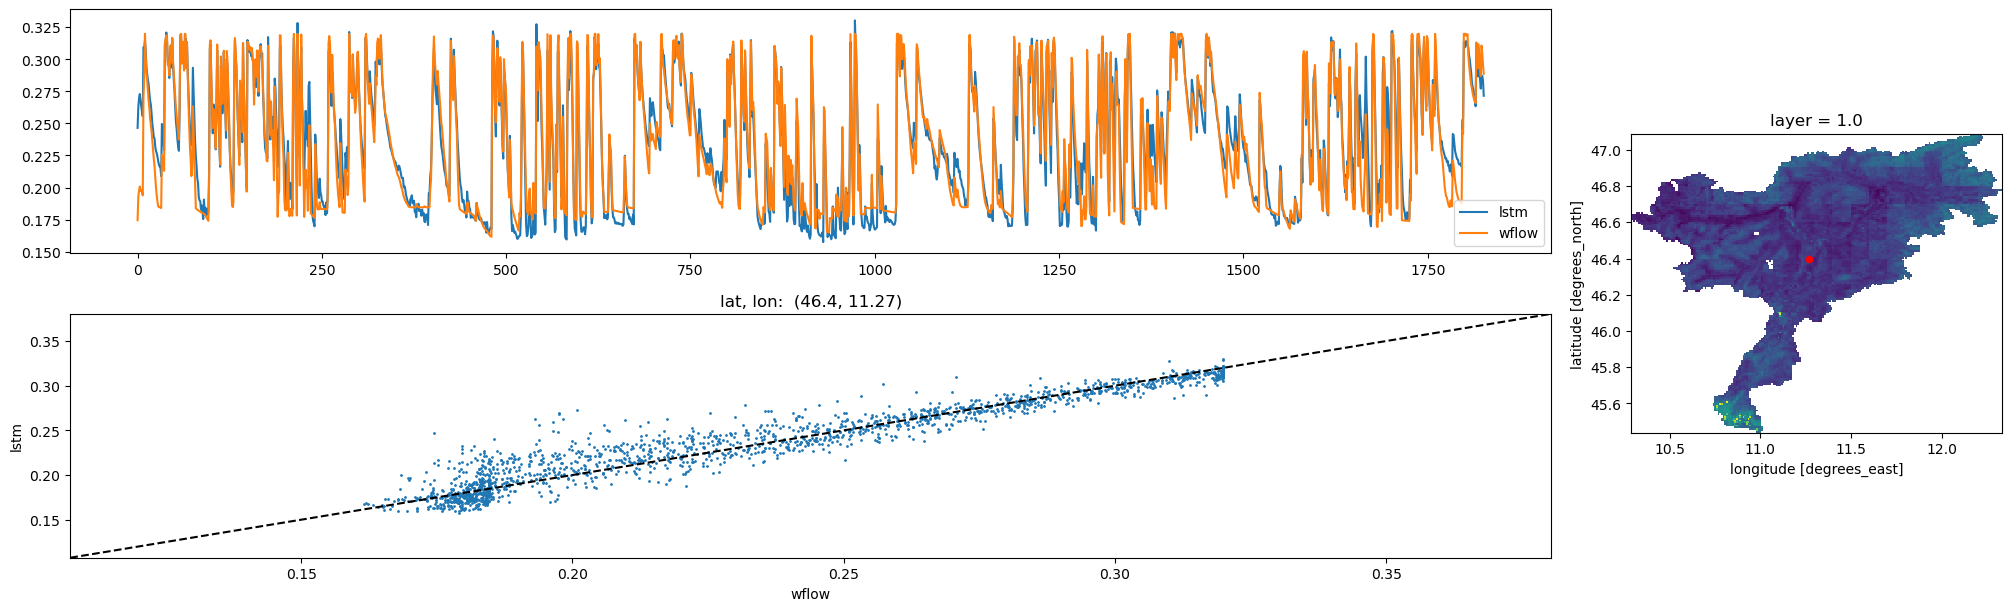

In [234]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5, 46.3, 46.4], lon = [11.4, 11.3, 11.3, 11.27])

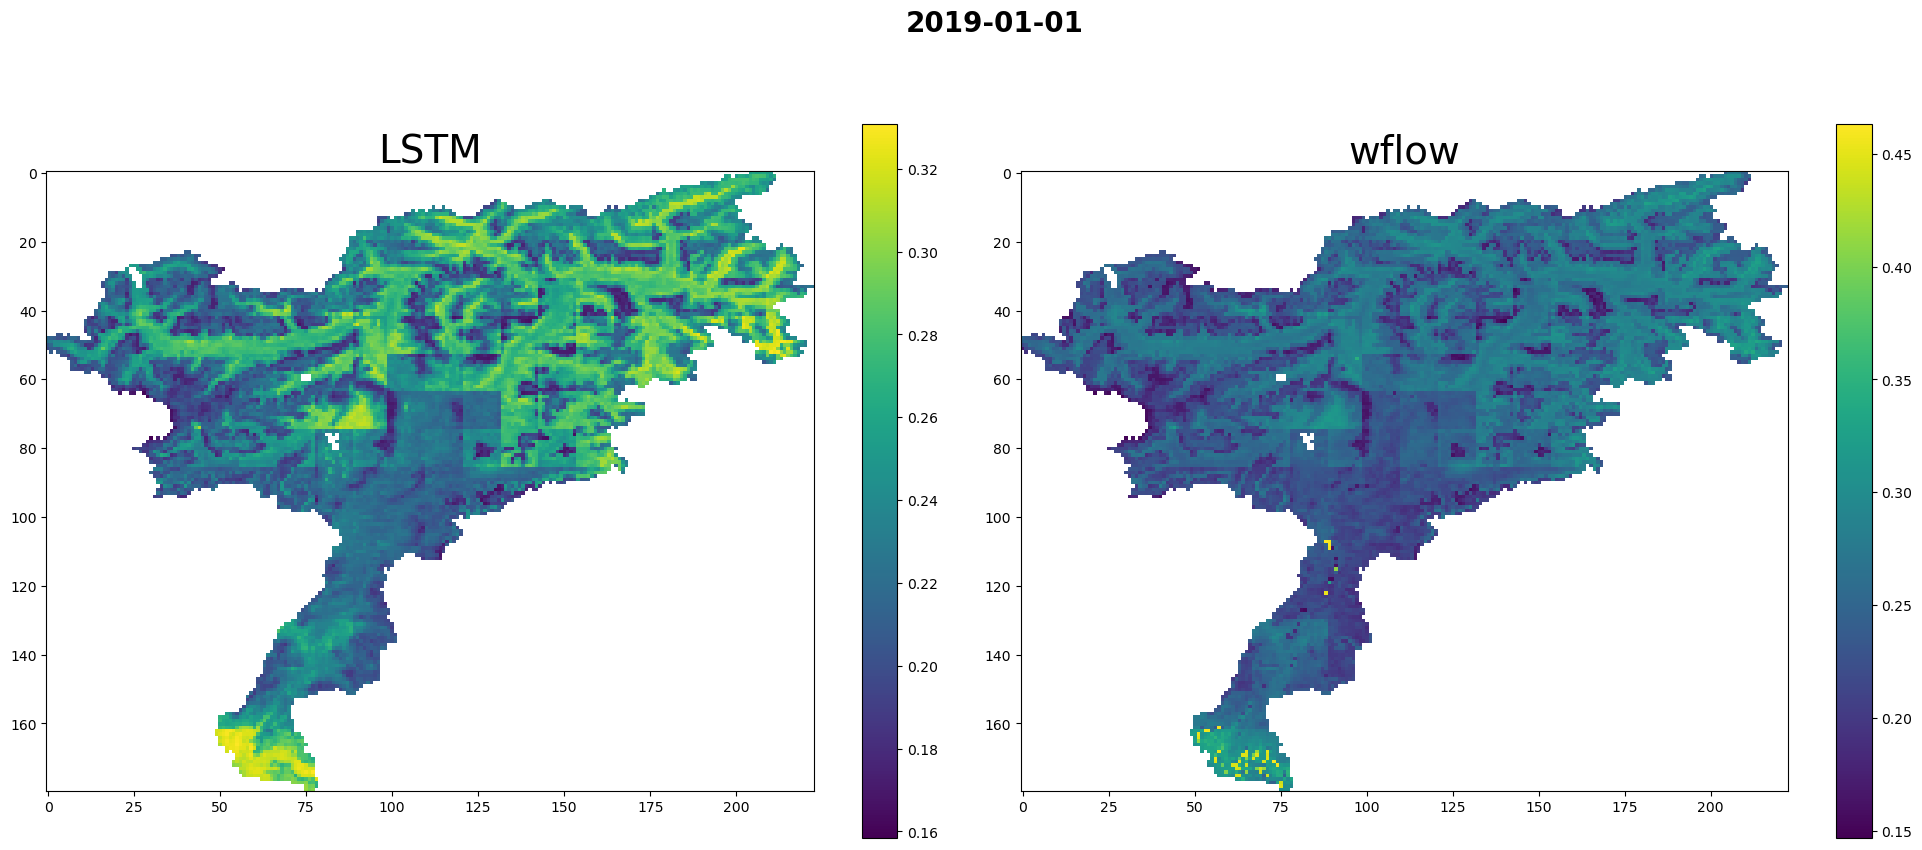

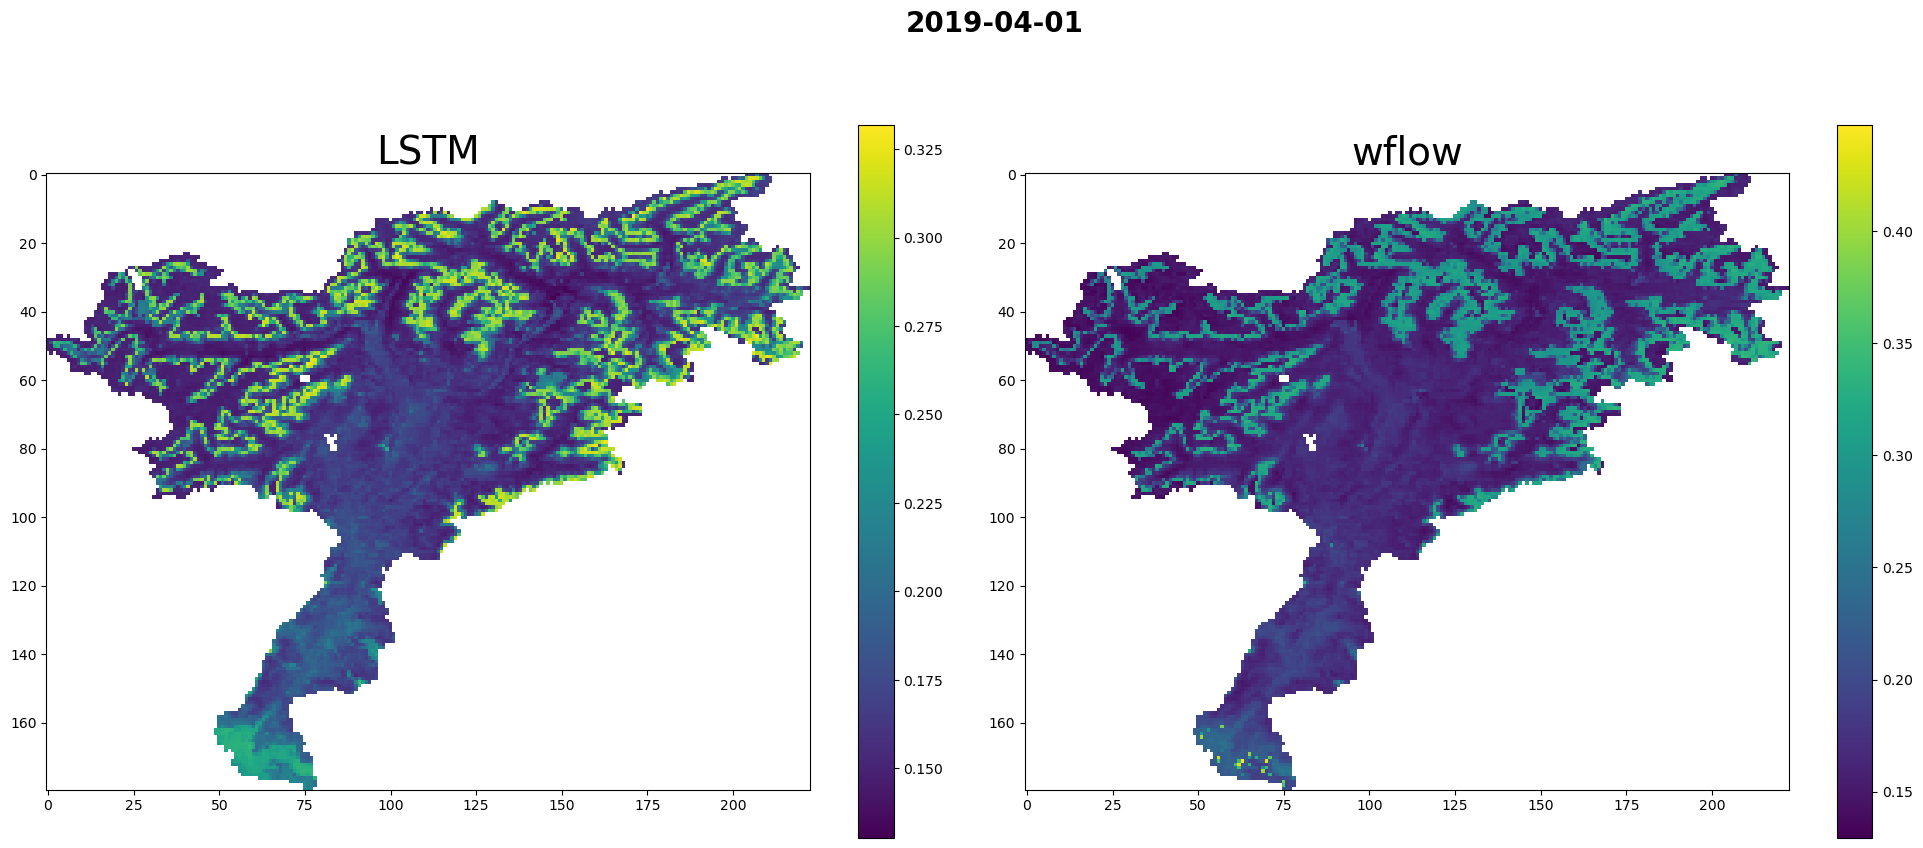

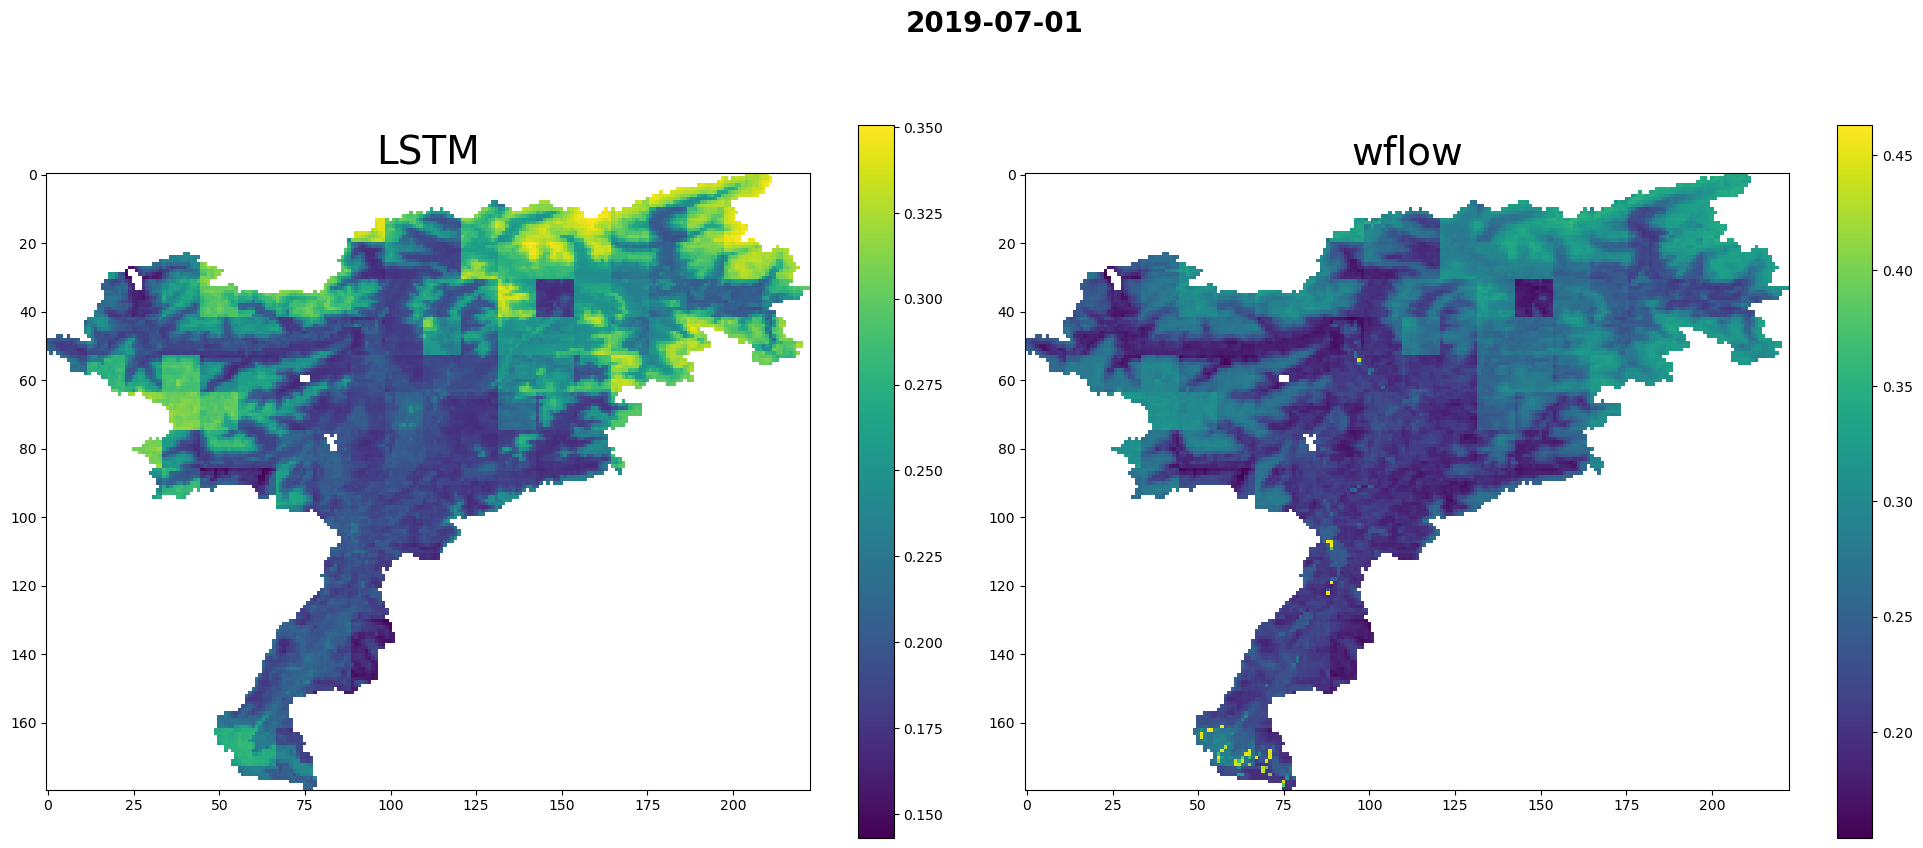

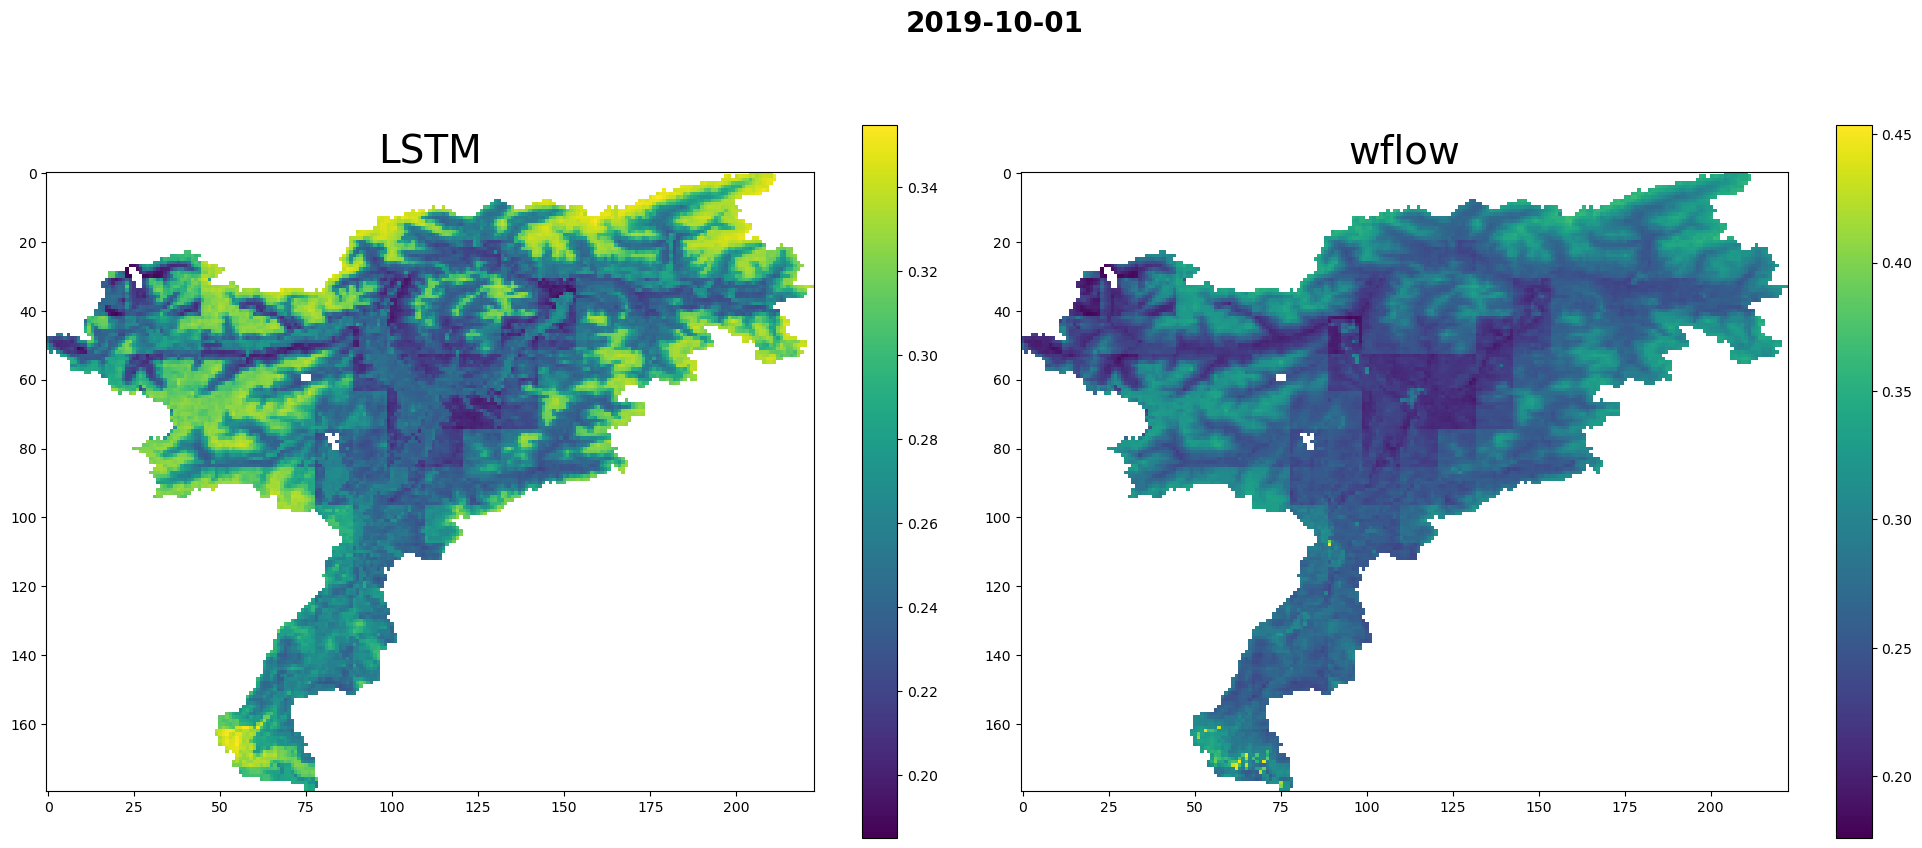

In [235]:
map_at_timesteps(y_target, y_pred,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])

## ET

In [236]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets[target_names].coords)
y_target_et.shape

(180, 223, 1827)

In [237]:
y_target_et = (y_target_et*y_std[1]) + y_m[1]

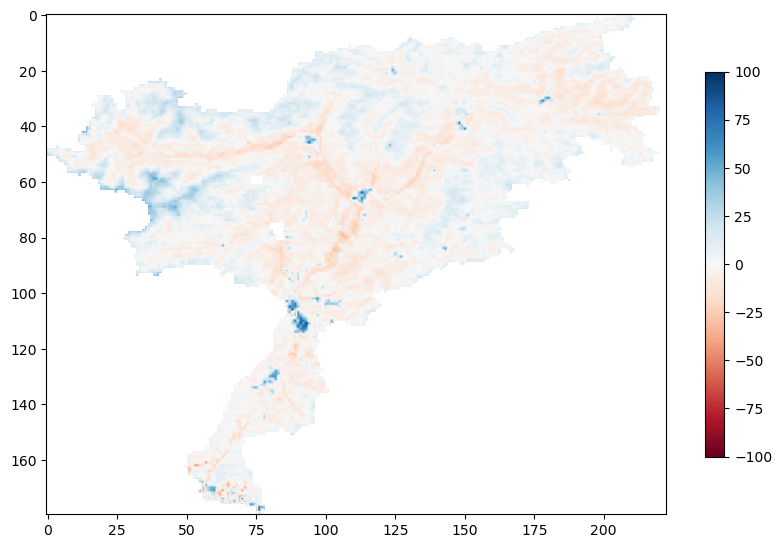

In [238]:
map_pbias(y_target_et, y_pred_et, figsize = (10, 10), kwargs_imshow = {"vmin":-100, "vmax":100 })

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


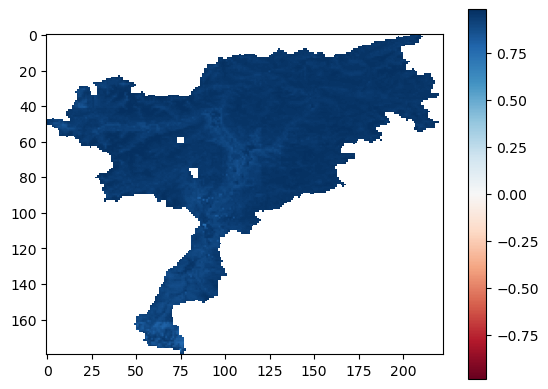

In [239]:
# correlation
map_pearson(y_target_et, y_pred_et)

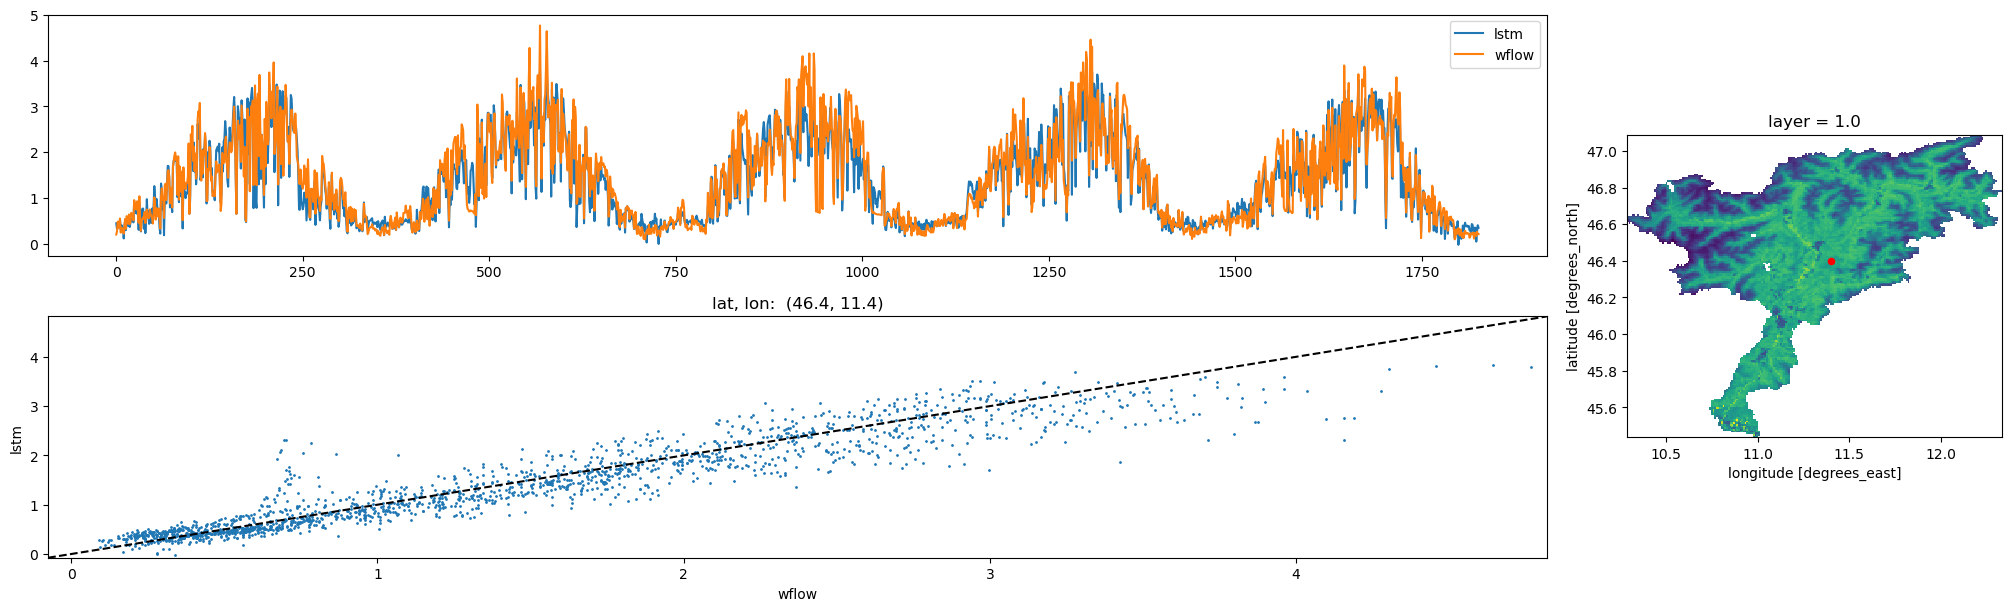

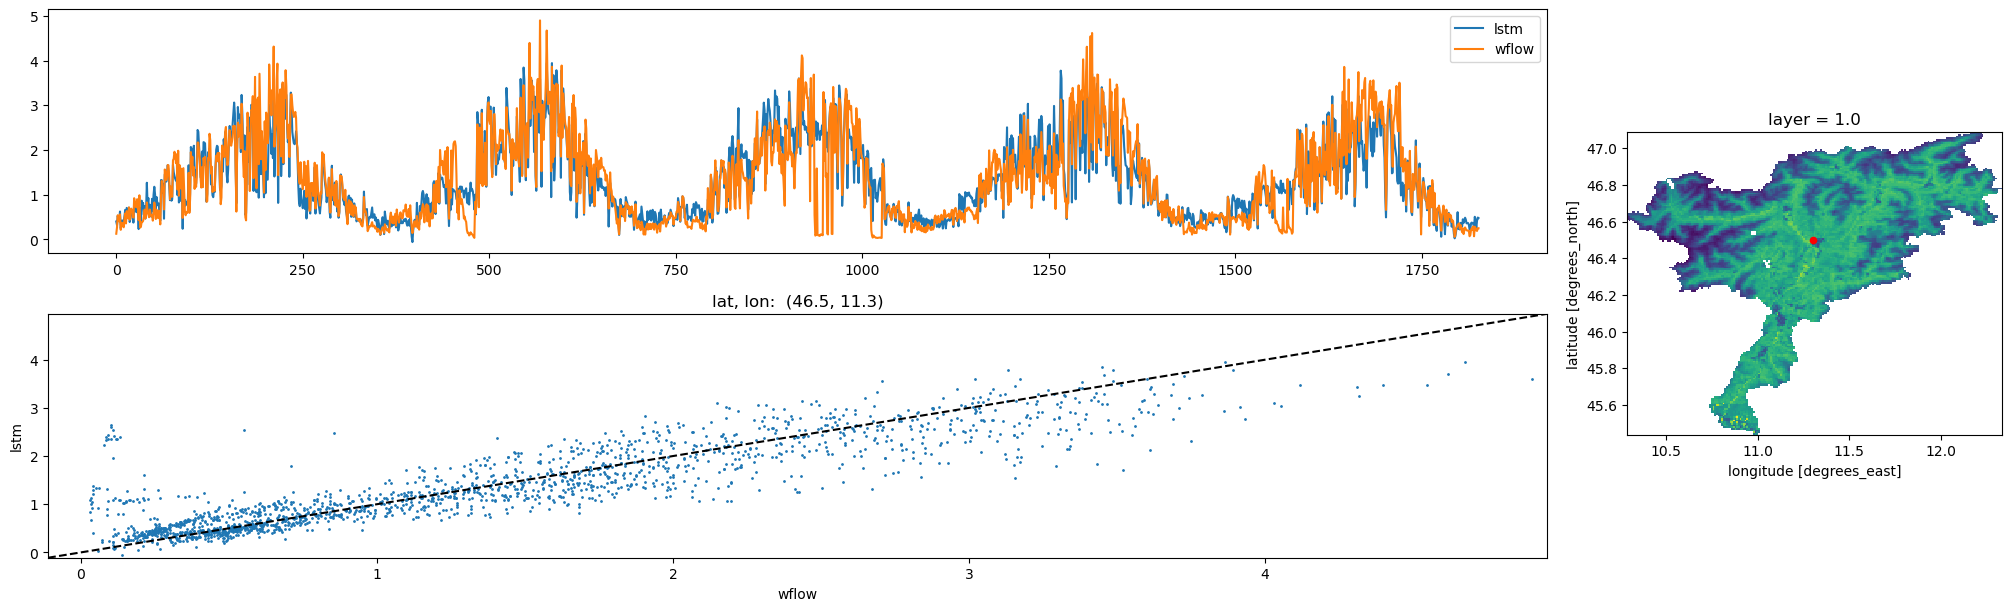

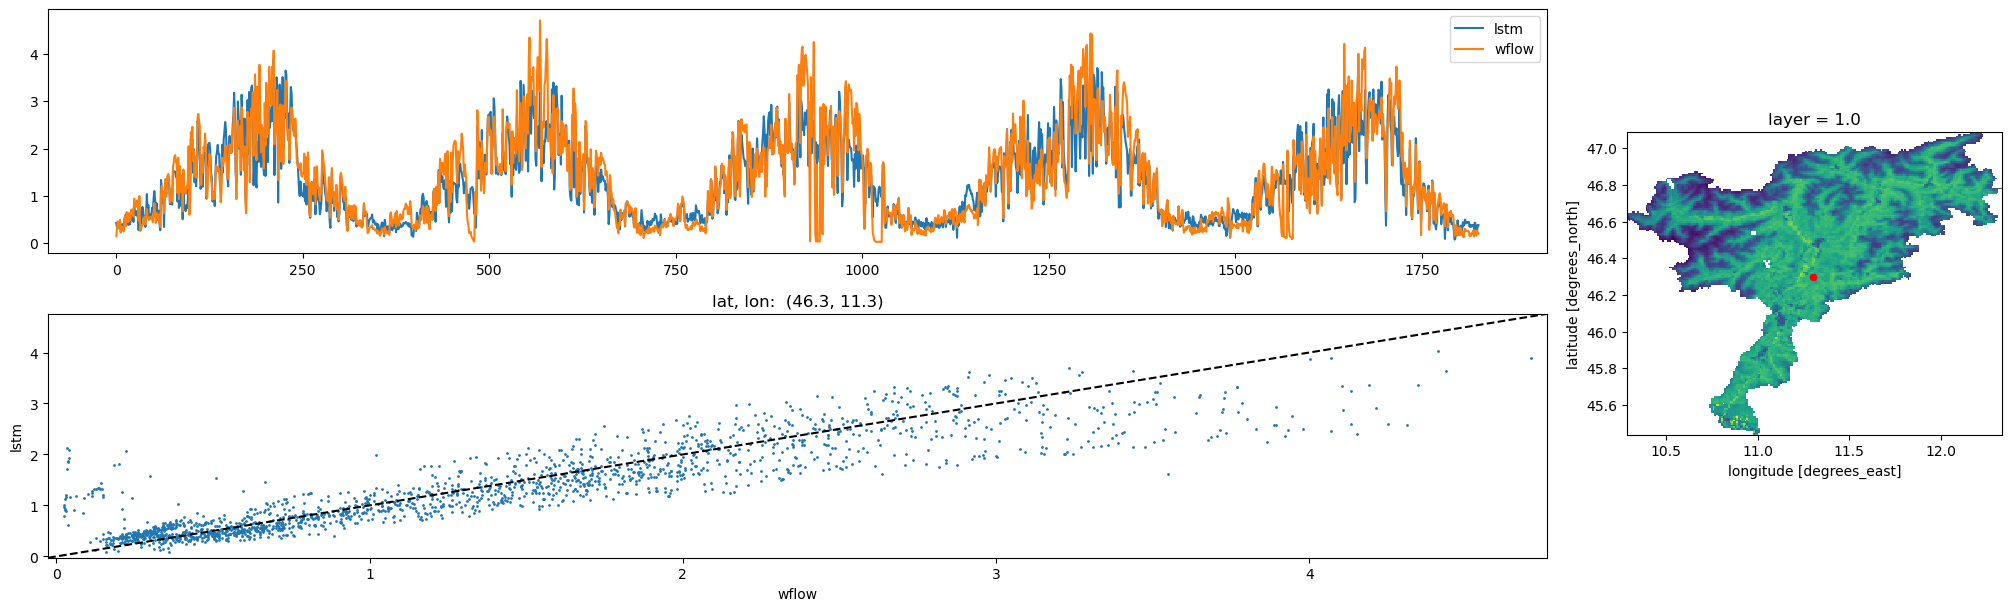

In [240]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 46.5, 46.3], lon = [11.4, 11.3, 11.3])

In [241]:
#plt.plot(np.unique(y_pred_et))

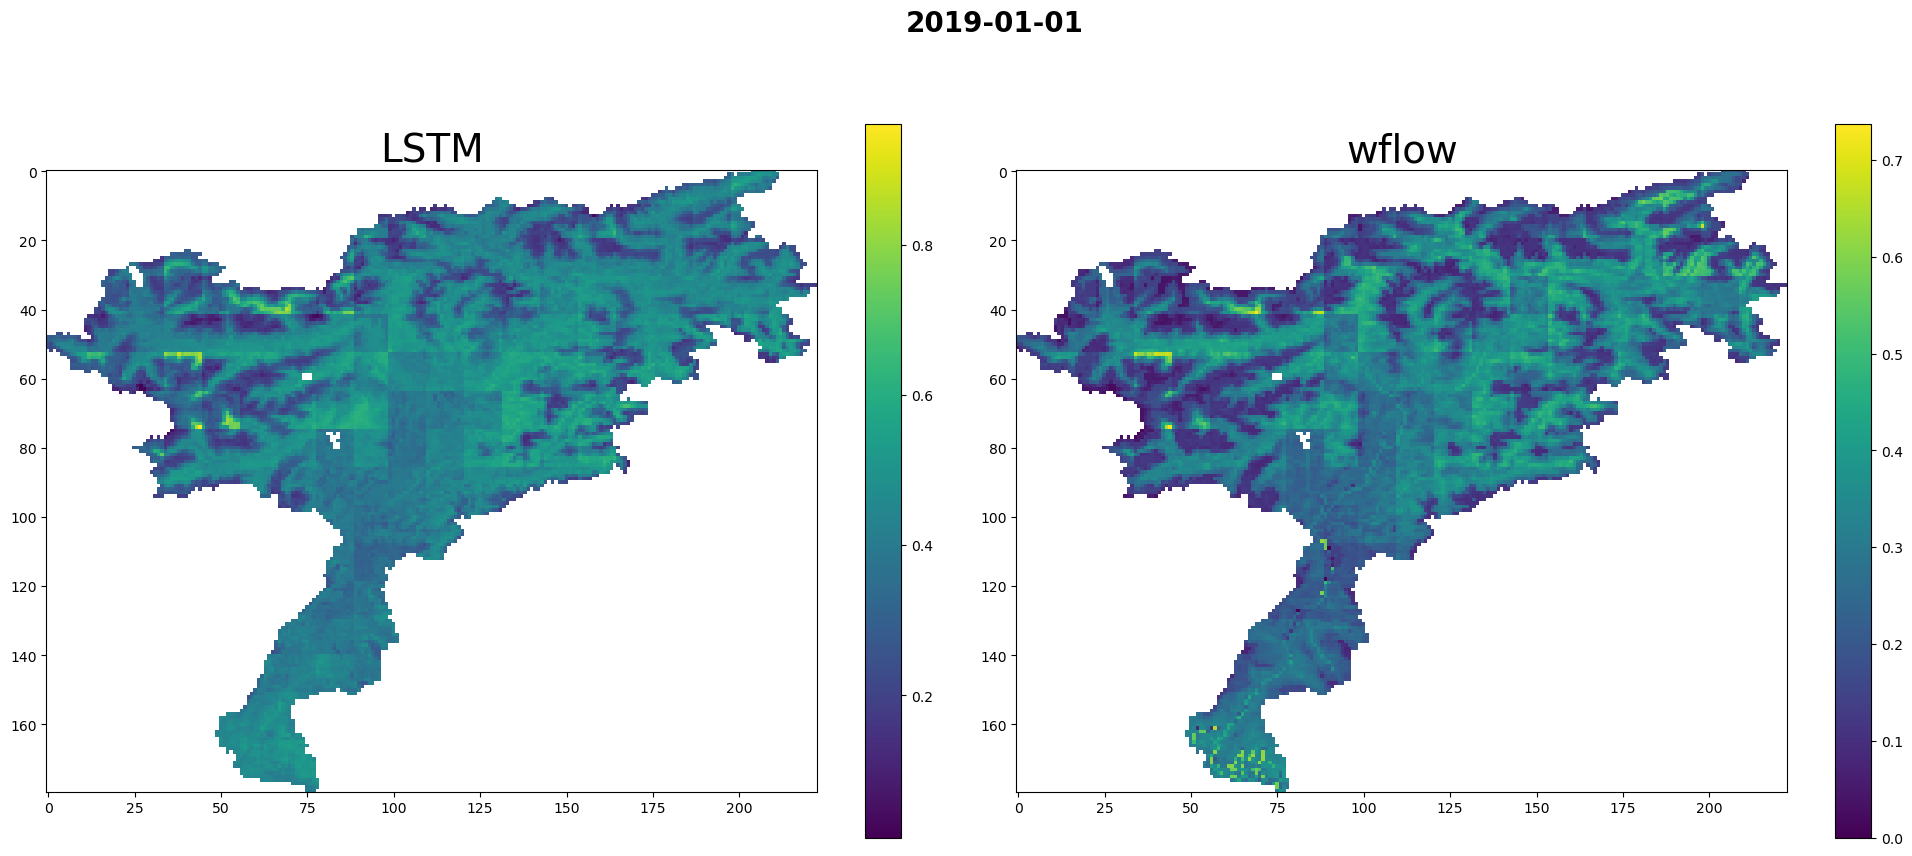

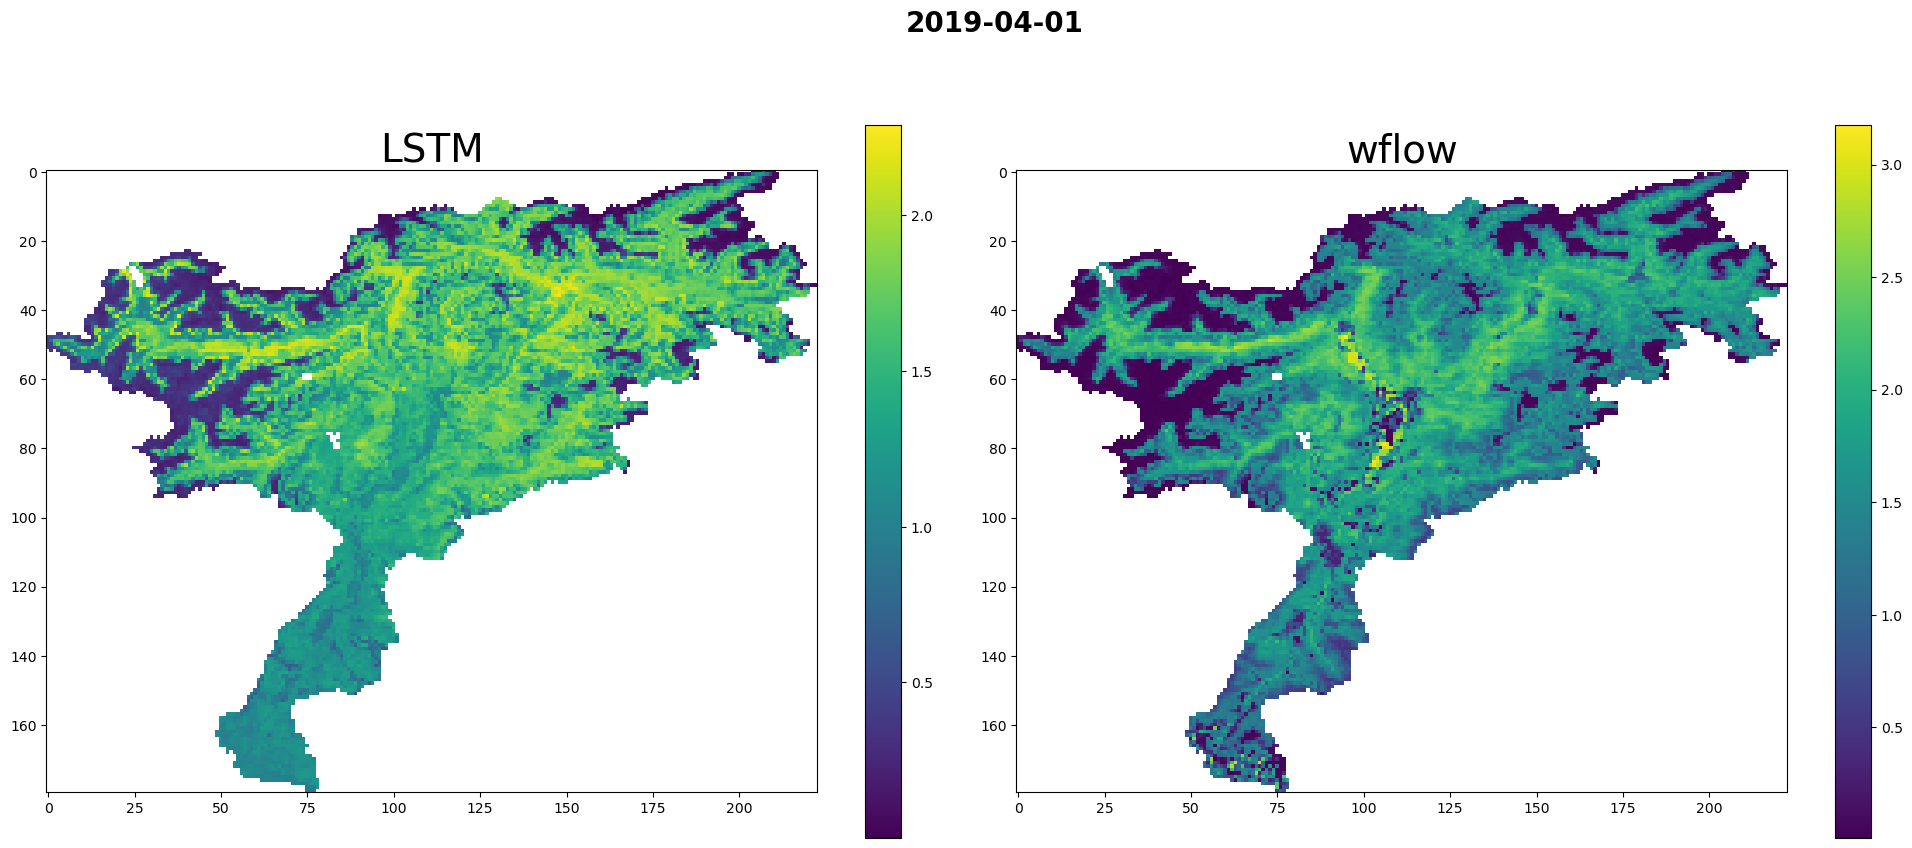

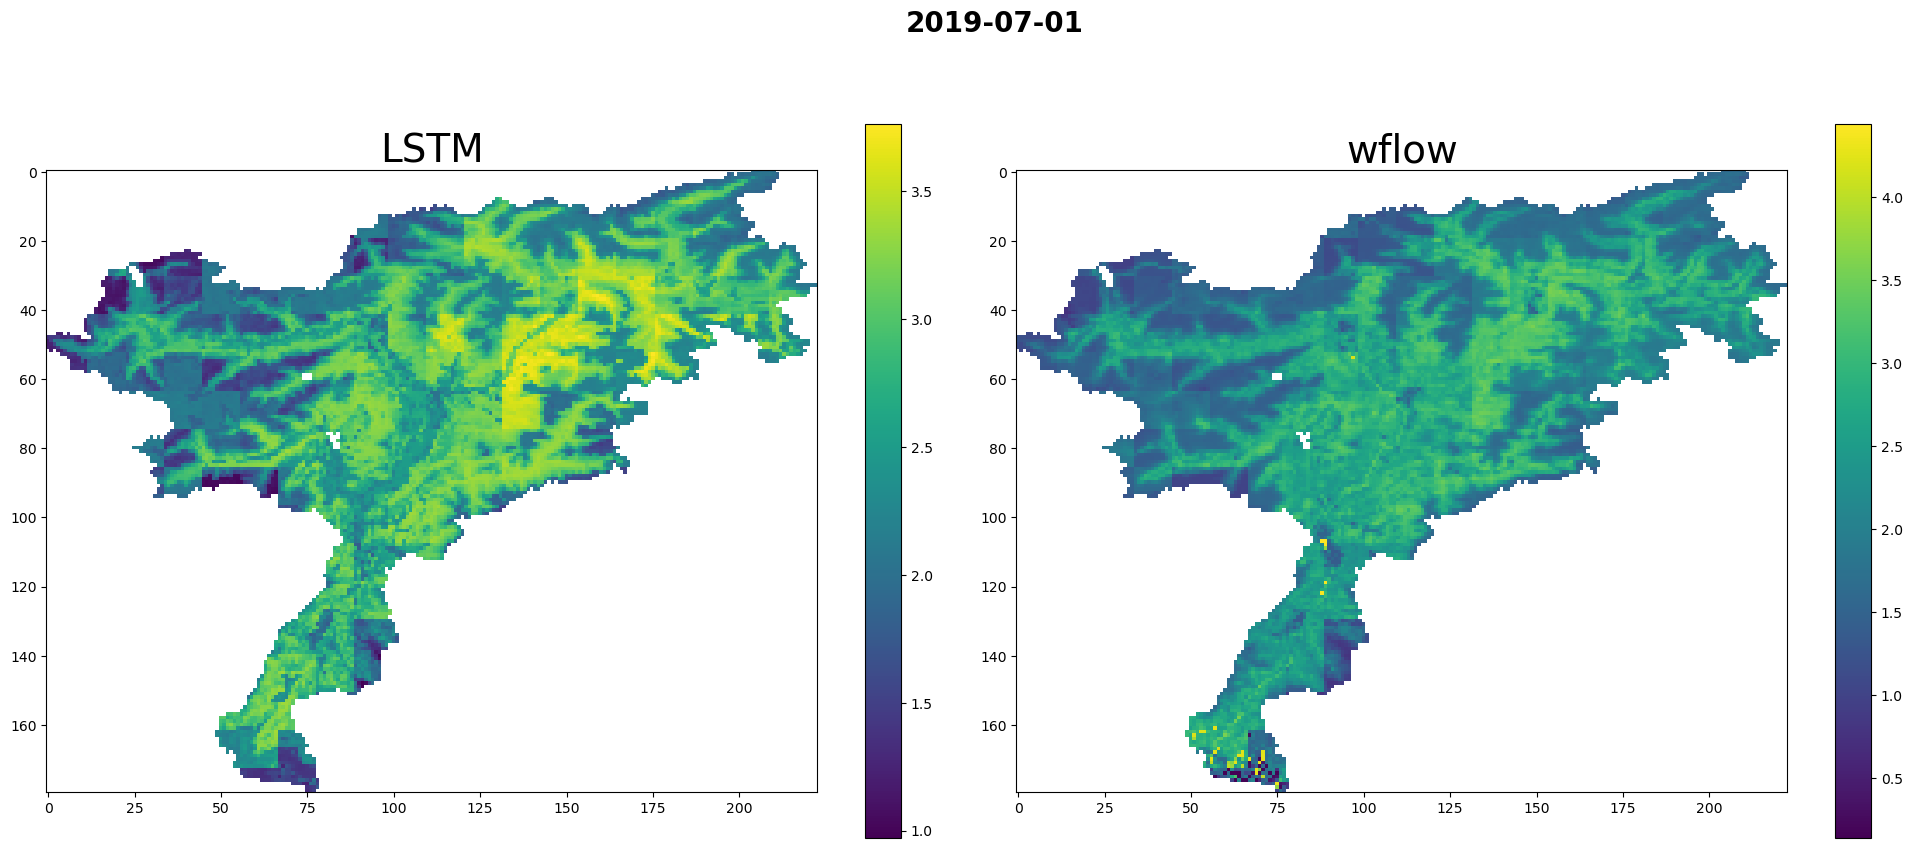

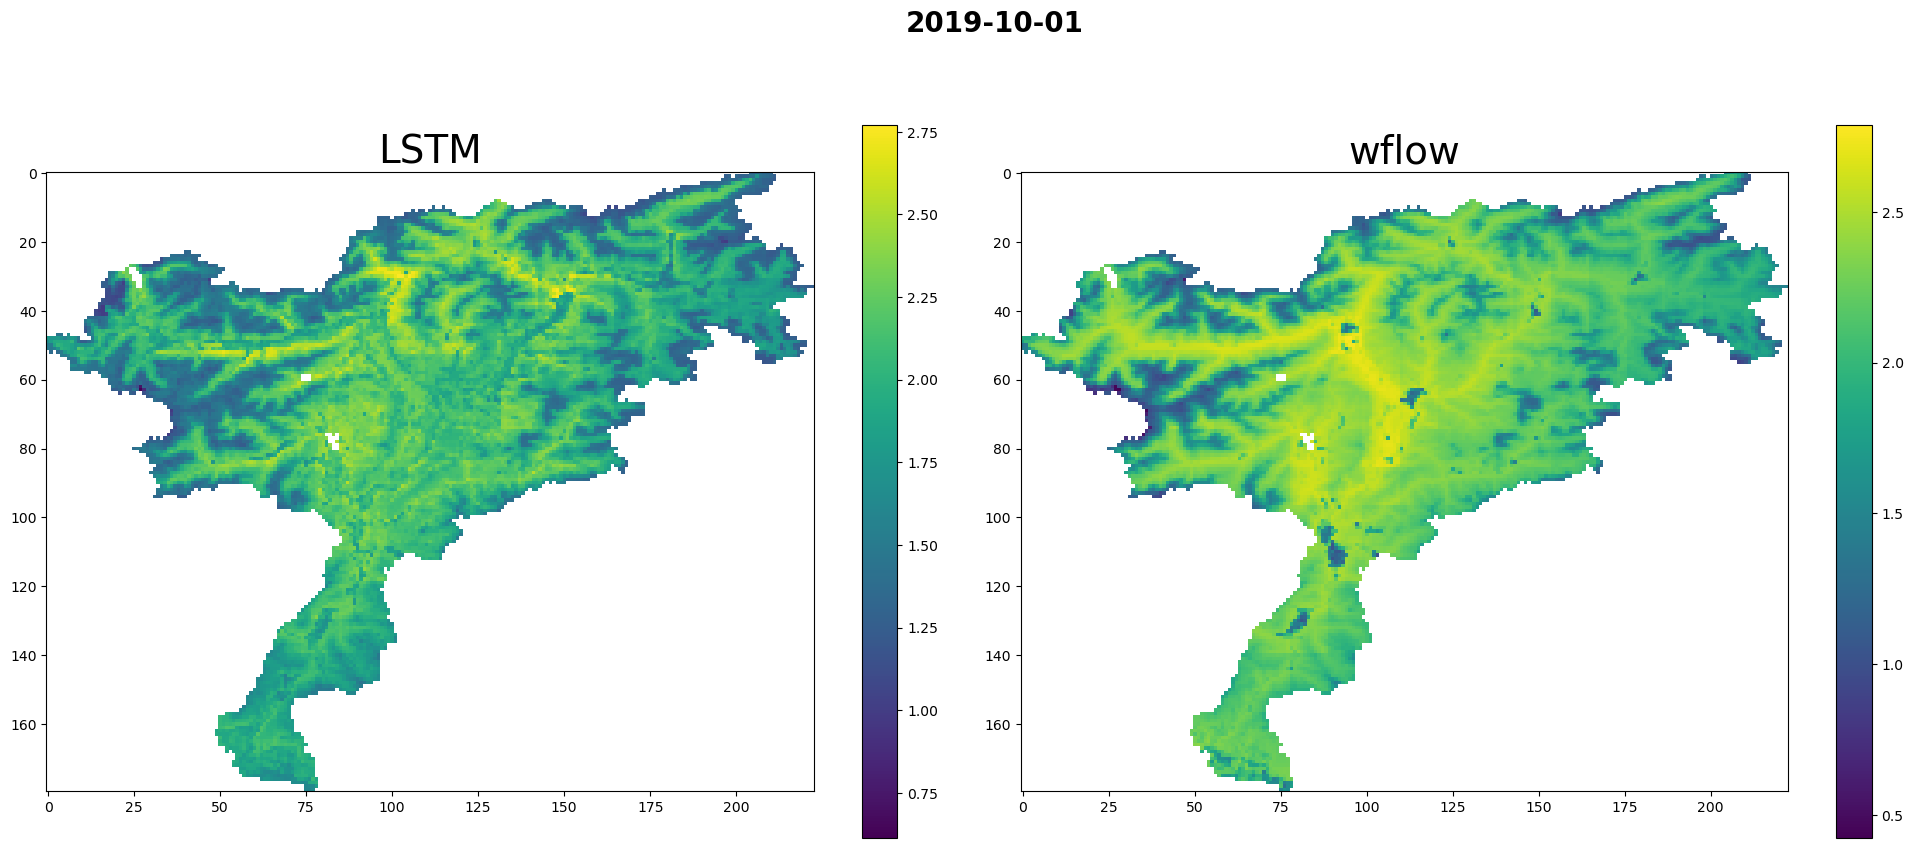

In [242]:
map_at_timesteps(y_target_et, y_pred_et,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])